# Bayesian DAE vs Traditional DAE (Convolutional)



## Data loading and processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
trainval_data = datasets.FashionMNIST(root='data', train=True,
                                      download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                     download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:07<00:00, 3767024.63it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 324915.83it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5383825.66it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11577628.41it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
train_data, val_data = random_split(trainval_data, [50_000, 10_000])

# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

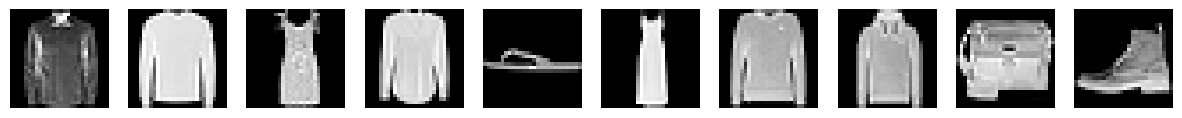

In [5]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

In [44]:
def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

class ConvolutionalBDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.2, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

class ConvolutionalDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.3, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

## Noise schemes

In [8]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Training Process

### Training functions

In [9]:
def train(train_loader, net, optimizer, criterion, noise_factor):
  total_loss = 0

  for i, data in enumerate(train_loader):

        images, _ = data
        # images = images.view(images.size(0), -1)

        # ADD NOISE PROCESS
        corrupted_images = add_gaussian_noise(images, noise_factor)

        images = images.to(device)
        corrupted_images = corrupted_images.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(corrupted_images)

        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        total_loss += loss.item() * images.size(0)

  avg_loss = total_loss/len(train_loader.dataset)  # Compute average loss

  return avg_loss

In [10]:
def validation(val_loader, net, criterion, Nsamples, noise_factor):
  total_loss = 0

  # Use torch.no_grad to skip gradient calculation, not needed for evaluation
  with torch.no_grad():
      # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            # images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            # print('predictions_mean:', predictions_mean.shape)
            # outputs = net.forward(corrupted_images)
            loss = criterion(predictions_mean, images) #changed from predictions_mean to outputs

            # keep track of loss and accuracy
            total_loss += loss.item() * images.size(0)

  return total_loss/len(val_loader.dataset)

### Training Procedure

##### DAE

In [29]:
#Set random seed
torch.manual_seed(42)

traditional_convolutional_model = ConvolutionalDAE().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(traditional_convolutional_model.parameters(), lr=learning_rate)

noise_factor = 0.2

num_epochs = 1


for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, traditional_convolutional_model, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 3/3 [14:01<00:00, 280.47s/it]

Finished Training


##### BDAE

In [52]:
bayesian_convolutional_model = ConvolutionalBDAE().to(device)
criterion = nn.MSELoss()
# learning_rate = 1e-3
optimizer = torch.optim.Adam(bayesian_convolutional_model.parameters(), lr=learning_rate)

num_epochs = 1

Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, bayesian_convolutional_model, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 1/1 [04:47<00:00, 287.46s/it]

Finished Training


## Visualizations Convolutional

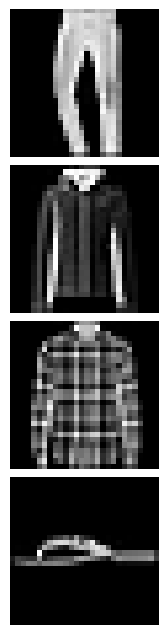

In [53]:
num_images = 4

# Function to plot the images
def plot_images(images, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(num_images):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()


# Initialize images
# Get a different set of 8 images and their labels from the test dataset
start_index = 5  # Change this to select a different starting point
images, labels = zip(*[(test_data[i][0], test_data[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(images, 0.05, vmax=1)

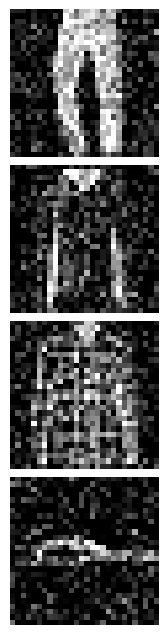

In [54]:
torch_images = torch.stack(images)

noisy_images = add_gaussian_noise(torch_images, noise_factor)
plot_images(noisy_images, 0.05)

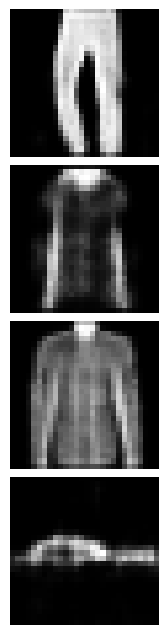

In [55]:
noisy_images_flattened = noisy_images.to(device)
traditional_convolutional_model.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = traditional_convolutional_model.sample_predict(noisy_images_flattened, 10)

plot_images(predictions_mean.view(-1,28,28).cpu(), 0.05)

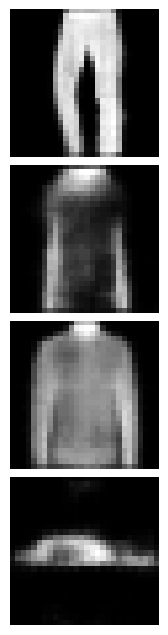

In [56]:
bayesian_convolutional_model.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = bayesian_convolutional_model.sample_predict(noisy_images.to(device), Nsamples)

plot_images(predictions_mean.view(-1,28,28).cpu(), 0.05)

0.033776205


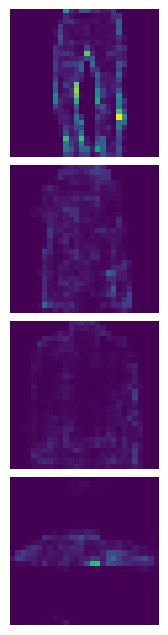

In [58]:
max_pixel = np.max(predictions_var.cpu().numpy()[:4])
print(max_pixel)

plot_images(predictions_var.view(-1,28,28).cpu(), 0.05, 'viridis', vmax=max_pixel)

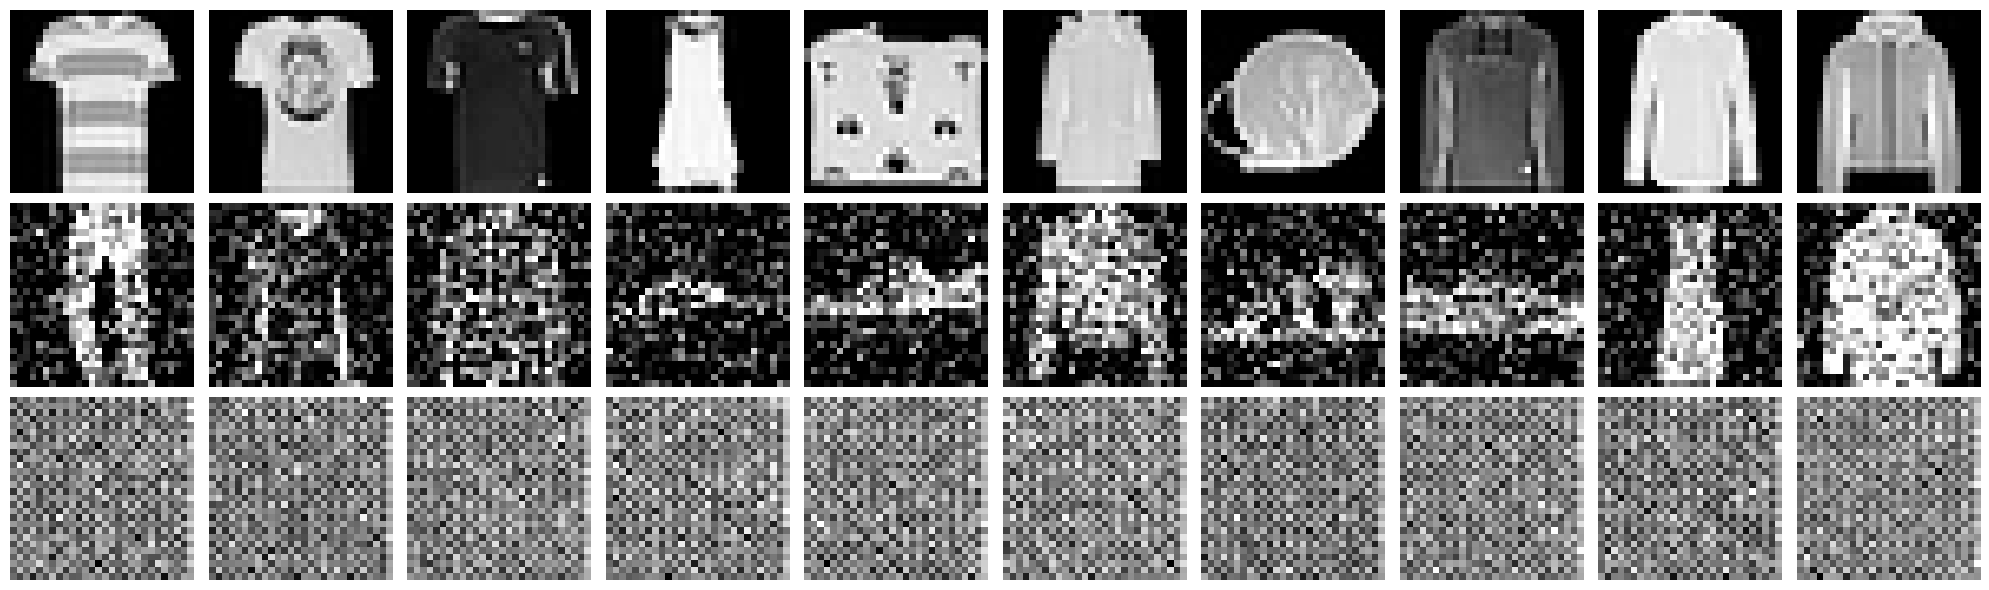

In [26]:
def display_images(train_loader, net):
    # Get the first batch of images
    images, _ = next(iter(train_loader))

    # Add noise to images
    corrupted_images = add_gaussian_noise(torch_images, noise_factor)

    corrupted_images = corrupted_images.to(device)

    # Pass corrupted images through the network to get denoised images
    net.eval()
    with torch.no_grad():
        denoised_images = net(corrupted_images)

    # Convert images to numpy for visualization
    images_np = images.numpy()
    corrupted_images_np = corrupted_images.view(denoised_images.size(0), 1, 28, 28).cpu().numpy()
    denoised_images_np = denoised_images.view(denoised_images.size(0), 1, 28, 28).cpu().numpy()

    # Display images
    fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
    for i in range(10):
        # Original images
        ax = axes[0, i]
        ax.imshow(images_np[i].transpose(1, 2, 0), cmap='gray')
        ax.axis('off')

        # Corrupted images
        ax = axes[1, i]
        ax.imshow(corrupted_images_np[i].transpose(1, 2, 0), cmap='gray')
        ax.axis('off')

        # Denoised images
        ax = axes[2, i]
        ax.imshow(denoised_images_np[i].transpose(1, 2, 0), cmap='gray')
        ax.axis('off')

    axes[0, 0].set_ylabel('Original', size='large')
    axes[1, 0].set_ylabel('Corrupted', size='large')
    axes[2, 0].set_ylabel('Denoised', size='large')

    plt.tight_layout()
    plt.show()

display_images(train_loader, bayesian_convolutional_model)

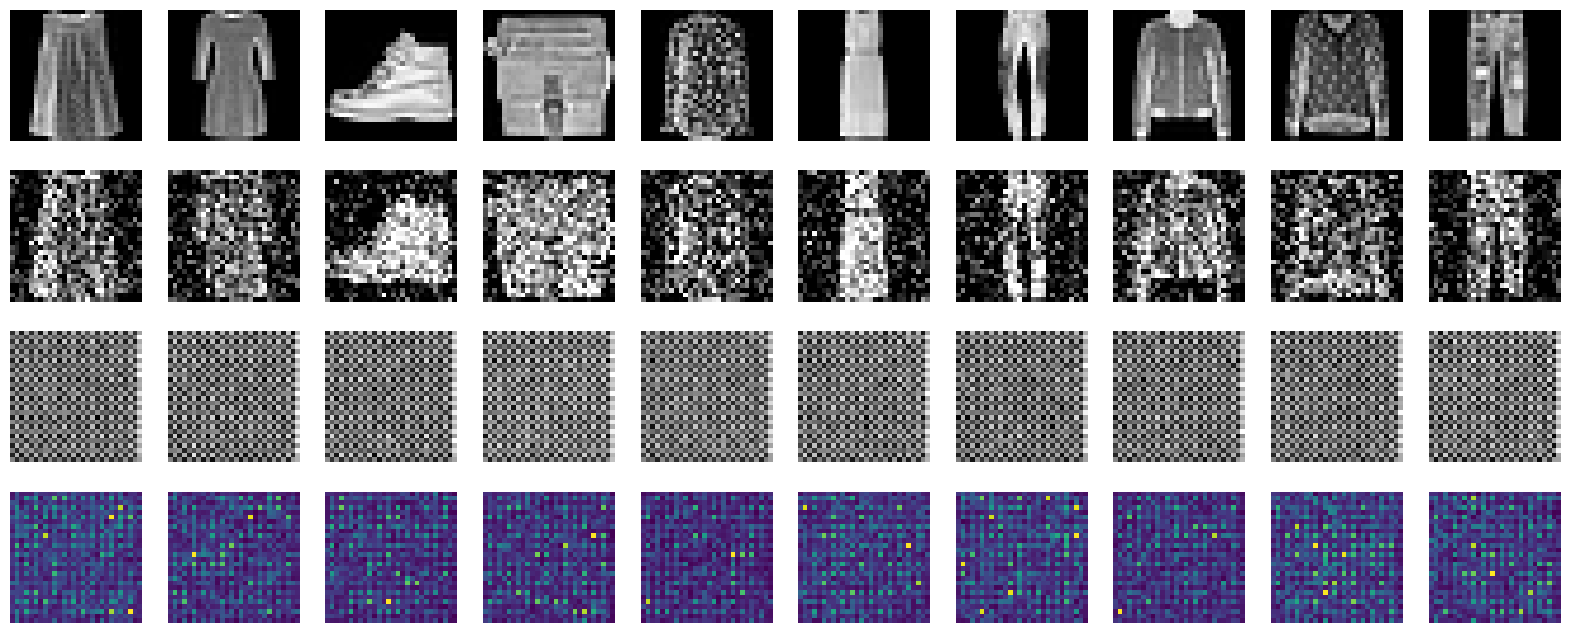

In [27]:
def plot_mean_variance(train_loader):
  images, _ = next(iter(train_loader))
  # Add noise to images
  corrupted_images = add_gaussian_noise(images, noise_factor)

  corrupted_images = corrupted_images.to(device)

  bayesian_convolutional_model.eval()
  with torch.no_grad():
      _, predictions_mean, predictions_var = bayesian_convolutional_model.sample_predict(corrupted_images, Nsamples)


  # Assuming predictions_mean and predictions_var are tensors
  first_ten_mean = predictions_mean[:10]  # Extracting the first ten samples from predictions_mean
  first_ten_var = predictions_var[:10]    # Extracting the first ten samples from predictions_var

  # Reshaping the samples back into images
  first_ten_mean_images = first_ten_mean.view(-1, 28, 28)  # Assuming images are 28x28
  first_ten_var_images = first_ten_var.view(-1, 28, 28)    # Assuming images are 28x28

  # Assuming images are 28x28
  image_size = 28

  # Extracting the first ten samples from the batch
  clean_images = images[:10]
  corrupted_images_subset = corrupted_images.cpu()[:10]
  mean_images = first_ten_mean_images.cpu()
  var_images = first_ten_var_images.cpu()

  # Plotting the images
  fig, axs = plt.subplots(4, 10, figsize=(20, 8))

  for i in range(10):
      # Plot clean images
      im_clean = axs[0, i].imshow(clean_images[i].view(image_size, image_size), cmap='gray')
      axs[0, i].axis('off')

      # Plot corrupted images
      im_corrupted = axs[1, i].imshow(corrupted_images_subset[i].view(image_size, image_size), cmap='gray')
      axs[1, i].axis('off')

      # Plot denoised (mean) images
      im_mean = axs[2, i].imshow(mean_images[i], cmap='gray')
      axs[2, i].axis('off')

      # Plot uncertainty (variance) images
      im_var = axs[3, i].imshow(var_images[i], cmap='viridis')
      axs[3, i].axis('off')


  # Add colorbars for the uncertainty (variance) images
  # fig.colorbar(im_var, ax=axs[3, :], shrink=0.6)

  plt.show()

plot_mean_variance(train_loader)